<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3-ModelFitting/W1D3_Tutorial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 3, Tutorial 5
# Model Fitting: Polynomial regression 


#Tutorial Objectives

This is Tutorial 5 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of linear models by  generalizing to multiple linear regression (Tutorial 4). We then move on to polynomial regression (Tutorial 5). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 6) and two common methods for model selection, AIC and Cross Validation (Tutorial 7).  

In this tutorial, we will learn about a new model, polynomial regression, which is an extension of linear regression.

*   Learn how to structure our inputs for polynomial regression
*   Fit polynomial regression models of different complexity
* Plot and evaluate the polynomial regression fits



Video available at https://youtu.be/fGPSAjF2plofGPSAjF2plo


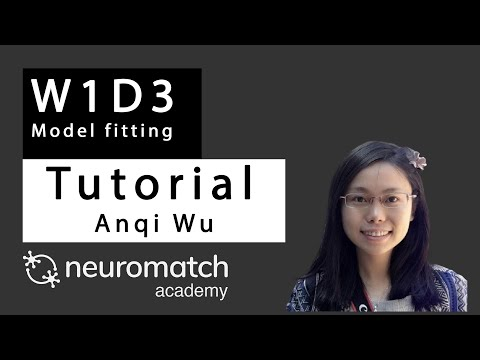

In [1]:
#@title Video Polynomial Regression
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="fGPSAjF2plo", width=854, height=480, fs=1)
print("Video available at https://youtu.be/fGPSAjF2plo" + video.id)
video


# Setup

In [2]:
#@title  Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
%matplotlib inline

In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vecto"r of measurements of shape (n_samples)
  
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  return np.linalg.inv(x.T @ x) @ x.T @ y


# Polynomial Regression

So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sort of relationships, including in neuroscience! For example, you can fit a linear regression model to predict neural activity from the visual stimulus the mouse is viewing (neural encoding). 

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is **polynomial regression**, an extension of linear regression.

Since polynomial regression is an extension of linear regression, everything you learned so far will come in handy now! The goal is the same: we want to predict the dependent variable $y_{n}$ given the input values $x_{n}$. The key change is the type of relationship between inputs and outputs that the model can capture. 

Linear regression models predict the outputs as a weighted sum of the inputs:

$$y_{n}= \theta_0 + \theta x_{n} + \epsilon_{n}$$

With polynomial regression, we model the outputs as a polynomial equation based on the inputs. In particular, we model the outputs as:

$$y_{n}= \theta_0 + \theta_1 x_{n} + \theta_2 x_{n}^2 + \theta_3 x_{n}^3 + \epsilon_{n}$$

We can change how complex a polynomial is fit by changing the order of the polynomial. The order of a polynomial refers to the highest power in the polynomial. The equation above is a third order polynomial because the highest value x is raised to is 3. We could add another term ($+ \theta_4 x_{n}^4$) to model an order 4 polynomial and so on.



## Data Generation

First, we will simulate some data to practice fitting polynomial regression models. We will generate noisy samples $x$ and then compute y according to $y = x^2 - x - 2 $, with some extra noise to make the model fitting harder.

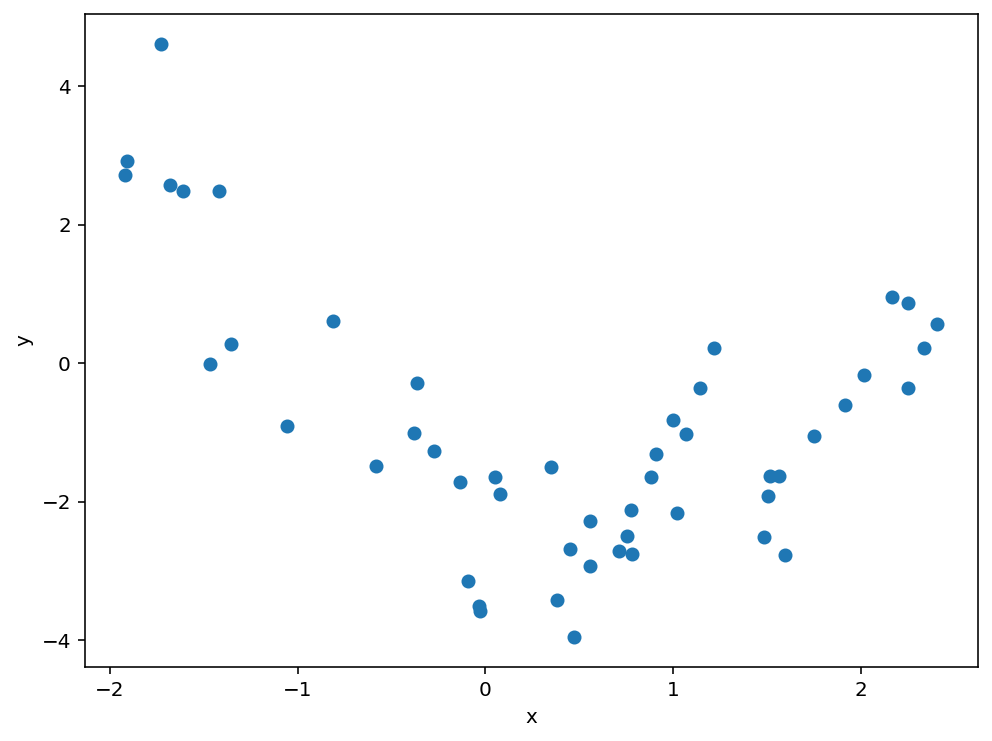

In [5]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(0)
n_samples = 50
x = np.random.uniform(-2, 2.5, n_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y =  x**2 - x - 2 + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y'); 

## Design matrix for polynomial regression

Now we have the basic idea of polynomial regression and some noisy data, let's begin! The key difference between fitting a linear regression model and a polynomial regression model lies in how we structure the input variables.  

For linear regression, we used $X = x$ as the input data. To add a constant bias (a y-intercept in a 2-D plot), we use $X = \big[ \boldsymbol 1, x \big]$, where $\boldsymbol 1$ is a column of ones.  When fitting, we learn a weight for each column of this matrix. So we learn a weight that multiples with column 1 - in this case that column is all ones so we gain the bias parameter ($+ \theta_0$). We also learn a weight for every column, or every feature of x, as we learned in the **Multiple Linear Regression** section in Part 1.

This matrix $X$ that we use for our inputs is known as a **design matrix**. We want to create our design matrix so we learn weights for $x^2, x^3,$ etc. Thus, we want to build our design matrix $X$ for polynomial regression of order $k$ as:

$$X = \big[ \boldsymbol 1 , x^1, x^2 , \ldots , x^k \big],$$

where $\boldsymbol{1}$ is the vector the same length as $x$ consisting of of all ones, and $x^p$ is the vector or matrix $x$ with all elements raised to the power $p$. Note that $\boldsymbol{1} = x^0$ and $x^1 = x$ 

### Exercise: Structure design matrix

Create a function (`make_design_matrix`) that structures the design matrix given the input data and the order of the polynomial you wish to fit

In [6]:
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: The design matrix containing x raised to different powers
  """
  #################################################
  ## TODO for students: create the design matrix ##
  #################################################
    # Broadcast to shape (n x 1) if shape (n, ) so this function generalizes to multiple inputs
  if x.ndim == 1:
    x = x[:,None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1)) 

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  #for degree in range(1, order+1):
      #design_matrix = YOUR CODE HERE

  #comment this out when you've filled the function
  raise NotImplementedError("Student excercise: create the design matrix")
  return design_matrix

# Uncomment once the make_design_matrix function is complete
max_order = 5
# X_design = make_design_matrix(x, max_order)

In [7]:
# to_remove solution
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: The design matrix containing x raised to different powers
  """

  # Broadcast to shape (n x 1) if shape (n, ) so this function generalizes to multiple inputs
  if x.ndim == 1:
    x = x[:,None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1)) 

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix
  
max_order = 5
X_design = make_design_matrix(x, max_order)

## Fitting polynomial regression models

Now that we have the inputs structured correctly in our design matrix, fitting a polynomial regression is the same as fitting a linear regression model! All of the polynomial structure we need to learn is contained in how the inputs are structured in the design matrix. We can use the same least squares solution we computed in Tutorials 1 and 4. 

### Exercise: Fitting polynomial regression models with different orders 

Here, we will fit polynomial regression models to find the regression coefficients ($\theta_0, \theta_1, \theta_2,$ ...) by solving the least squares problem. Create a function `solve_poly_reg` that loops over different order polynomials (up to `max_order`), fits that model, and saves out the weights for each. You may invoke the `ordinary_least_squares` function from Tutorial 4. 

In [8]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): An array of shape (samples, ) that contains the input values 
    y (ndarray): An array of shape (samples, ) that contains the output values
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    dict: Each entry has the order as the key and the values are that models fitted weights
  """

  # Create a dictionary with polynomial order as keys, and np array of theta 
  # (weights) as the values
  theta_hat = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    ##################################################################################
    ## TODO for students: Create design matrix and fit polynomial model for this order ##
    ##################################################################################
    #X = YOUR CODE HERE
    #this_theta = YOUR CODE HERE
    theta_hat[order] = this_theta

    #uncomment when you've filled in the function
    raise NotImplementedError("Student exercise: fit a polynomial model")
  

  return theta_hat

# Uncomment once the solve_poly_reg function is complete
max_order = 5
# theta_hat = solve_poly_reg(x, y, max_order)


In [9]:
# to_remove solution

def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  
  Args:
    x (ndarray): An array of shape (samples, ) that contains the input values 
    y (ndarray): An array of shape (samples, ) that contains the output values
    max_order (scalar): The order of the polynomial we want to fit

  Returns:
    numpy array: (input_features, max_order+1) Each column contains the fitted 
    weights for that order of polynomial regression
  """

  # Create a dictionary with polynomial order as keys, and np array of theta 
  # (weights) as the values
  theta_hat = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hat[order] = this_theta

  return theta_hat

max_order = 5
theta_hat = solve_poly_reg(x, y, max_order)


## Visualizing polynomial fits

We've fit 5 different polynomials (orders 0-5) to our data. Let's qualitatively inspect the quality of our fits by plotting the fitted polynomials on top of the data. 

### Exercise: Plot polynomial fits

In order to see smooth curves, you will have to evaluate the fitted polynomials on a grid of $x$ values (you can have them range between the largest and smallest of the inputs present in the dataset).

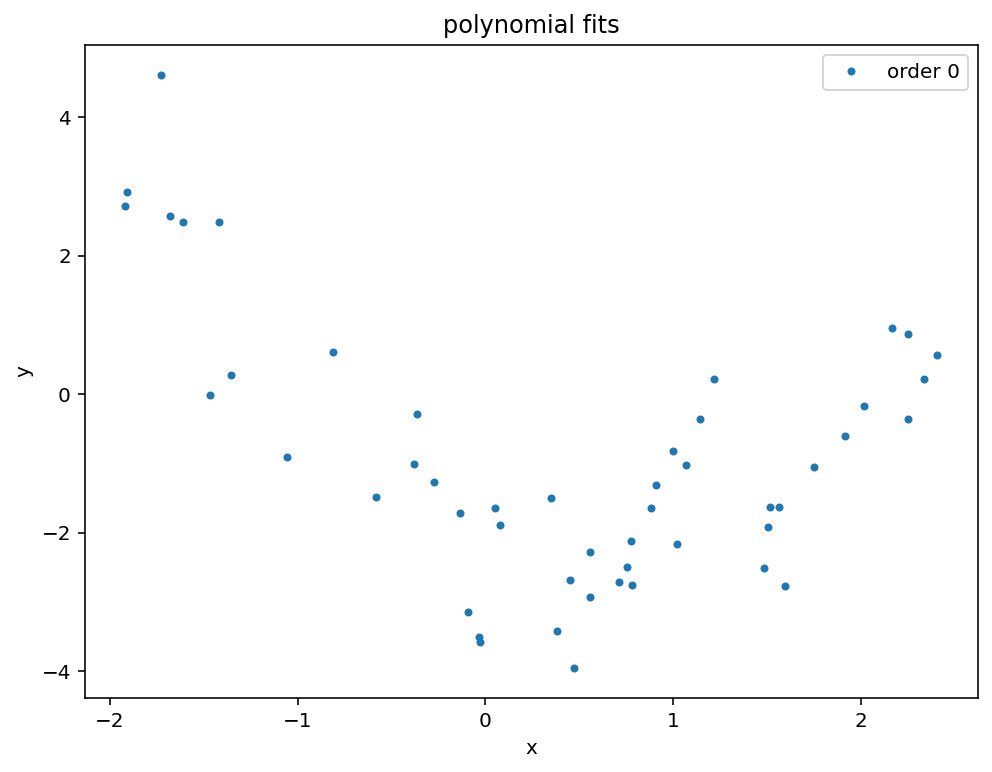

In [10]:
################################################################################
## TODO for students:
# Get a range of x values between the smallest and largest values of the input 
################################################################################

max_order = 5
plt.figure()

for order in range(0, max_order+1):
  ################################################################################
  ## TODO for students: For each order polynomial, create the design matrix and 
  ## compute the predicted y values given the previous fits. Plot each result
  ################################################################################
    #X_design = 
    #plt.plot(x_vec, np.dot(..., ....));

  pass

plt.ylabel('y')
plt.xlabel('x')
plt.plot(x, y, 'C0.');
plt.legend([f'order {o}' for o in range(max_order)], loc=1)
plt.title('polynomial fits');

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


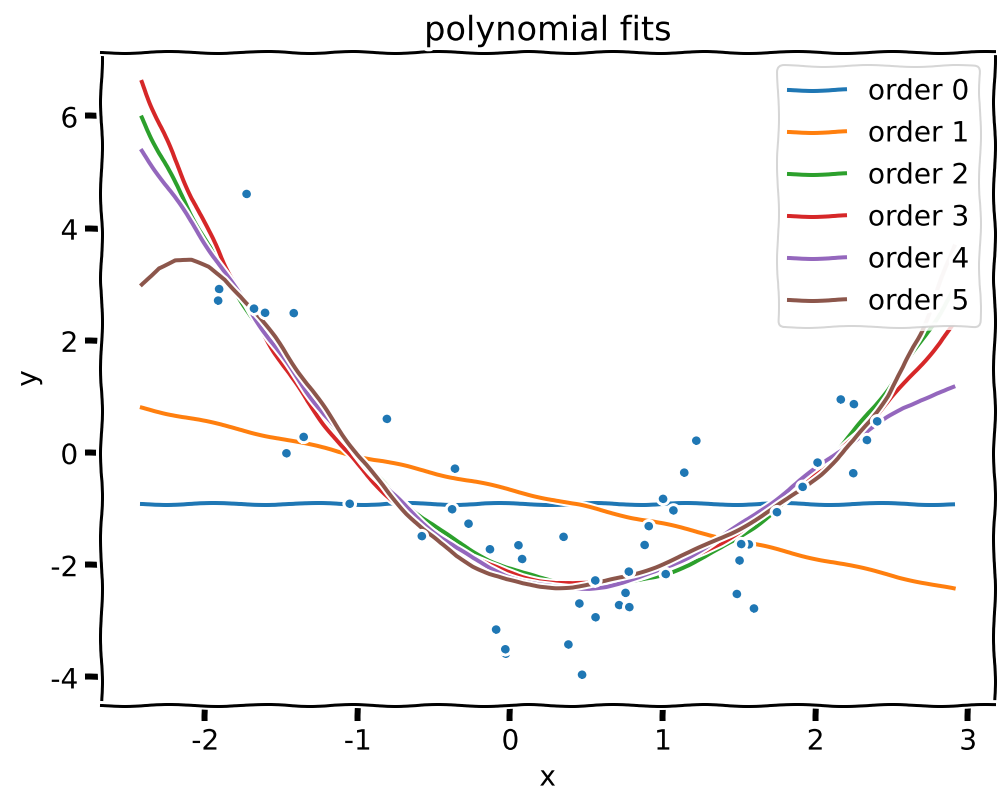

In [11]:
# to_remove solution

x_vec = np.linspace(x.min()-.5, x.max()+.5)

with plt.xkcd():
  plt.figure()

  for order in range(0, max_order+1):
    X_design = make_design_matrix(x_vec, order)
    plt.plot(x_vec, np.dot(X_design, theta_hat[order]));

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order+1)], loc=1)
  plt.title('polynomial fits')
  plt.show()

## Evaluating fit quality

As with linear regression, we can compute mean squared error (MSE) to get a sense of how well the model fits the data. 

We compute MSE as:

$$ MSE = \frac 1 N ||y - \hat y||^2 = \sum_{i=1}^N (y_i - \hat y_i)^2 $$

where the predicted values for each model are given by $ \hat y = X \hat \theta$. 

*Which model (i.e. which polynomial order) do you think will have the best MSE?*

### Exercise: Compute MSE and compare models

We will compare the MSE for different polynomial orders with a bar plot.

In [12]:
################################################################################
## TODO for students: Loop over polynomial orders and:
## 0) Get the design matrix
## 1) Get predictions as you did in previous exercise
## 2) Compute MSE
## Should output mse, a numpy array of size(max_order+1,)) where each entry is the
## MSE for that order polynomial model
################################################################################""
##uncomment below and fill in with your code

mse = np.zeros((max_order+1))
#for order in range(0, max_order+1):
  #X_design = 
  #y_hat = 
  #residuals = 
  #mse[order] = 

# Uncomment once above exercise is complete
# with plt.xkcd():
#   plt.bar(range(max_order+1), mse);
#   plt.ylabel('MSE')
#   plt.xlabel('polynomial order')
#   plt.title('comparing polynomial fits');


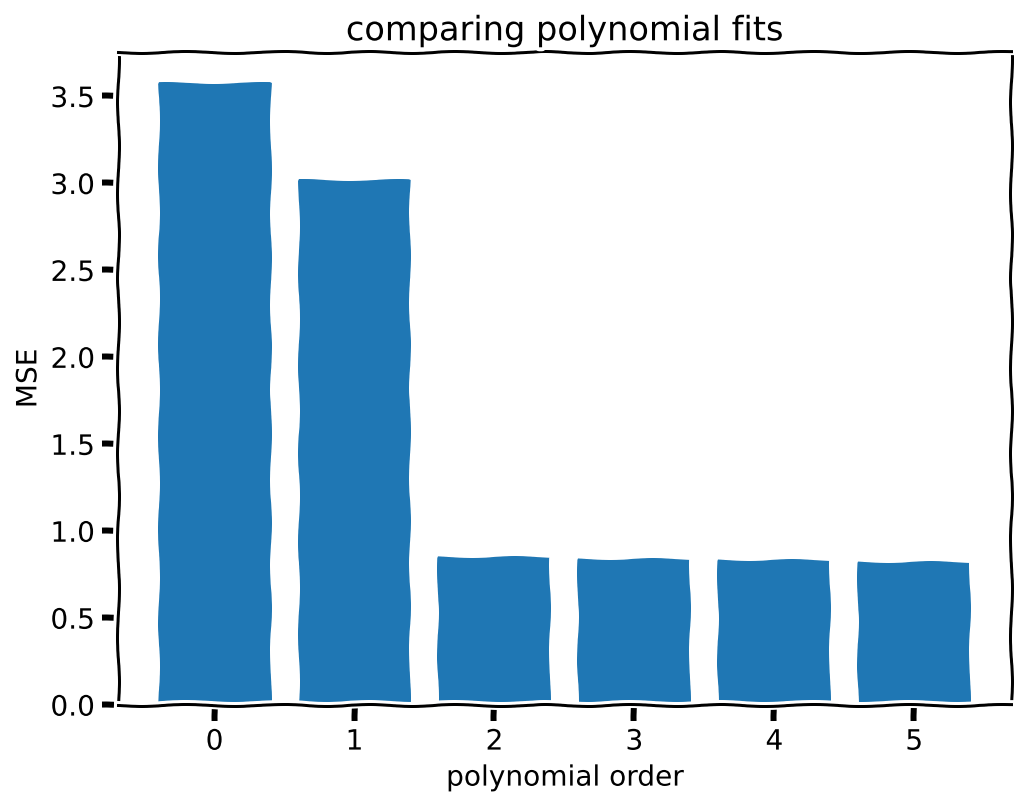

In [13]:
# to_remove solution
mse = np.zeros((max_order+1))
for order in range(0, max_order+1):
  X_design = make_design_matrix(x, order)
  y_hat = np.dot(X_design, theta_hat[order])
  residuals = y - y_hat
  mse[order] = np.mean(residuals ** 2)

with plt.xkcd():
  plt.bar(range(max_order+1), mse);
  plt.ylabel('MSE')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits');


# Summary

Polynomial regression is an extension of linear regression that can capture more complex patterns in the data.

* To change from a linear regression model to a polynomial regression model, we only have to change how the input data is structured

* We can choose the complexity of the model by changing the order of the polynomial model fit

* Higher order polynomial models tend to have lower MSE on the data they're fit with